In [1]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from cv_paper_plots import accuracy, slope, analysis

from importlib import reload

In [2]:
colors = ['k', 'gray', 'pink', 'red']
subjects = ['ec2', 'ec9', 'gp31', 'gp33']

In [3]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_all, linear_all, _ = pickle.load(f, encoding='latin1')

d = np.load(os.path.join(os.environ['HOME'], 'plots/ds/data/dataset_chance.npz'))
chance = d['chance_data']
training_size = d['training_size']

In [4]:
other_linear_accuracy = {}
other_deep_accuracy = {}
for key in ['c', 'v', 'p', 'm']:
    other_linear_accuracy[key] = np.zeros((len(subjects), 3, 10))
    other_deep_accuracy[key] = np.zeros((len(subjects), 3, 10))
for ii, s in enumerate(subjects):
    for style in ['_lin', '']:
        f_string = 'plots/model/data/{}_{}_hg_a{}_model_output.pkl'.format(s, s, style)
        with open(os.path.join(os.environ['HOME'], f_string), 'rb') as f:
            dicts, dicts2, y_dims, has_data = pickle.load(f, encoding='latin1')
        indices_dicts2, y_hat_dicts2, logits_dicts2 = dicts2
        mats = analysis.indx_dict2conf_mat(indices_dicts2, y_dims)
        c_mat, v_mat, cv_mat = mats
        acc = analysis.conf_mat2accuracy(c_mat, v_mat, cv_mat)
        (c_accuracy, v_accuracy, cv_accuracy, accuracy_per_cv,
         p_accuracy, m_accuracy) = acc
        if style == '_lin':
            d = other_linear_accuracy
        else:
            d = other_deep_accuracy
        d['c'][ii, 2] = c_accuracy
        d['v'][ii, 2] = v_accuracy
        d['p'][ii, 2] = p_accuracy
        d['m'][ii, 2] = m_accuracy
    print(s, cv_accuracy.mean())

ec2 0.358461538462
ec9 0.0632911392405
gp31 0.100580270793
gp33 0.211851851852


In [5]:
fracs = sorted(deep_all.keys())

# CV Accuracy

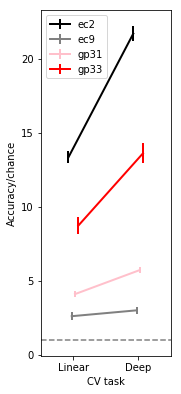

In [11]:
reload(accuracy)
plt.close()
f = plt.figure(figsize=(3, 6))

ax_cv = f.add_axes([.2, .1, .6, .8])

key = fracs[-1]
accuracy.plot_cv_accuracy(deep_all[key], linear_all[key], chance[0, :, -1], subjects, colors, ax_cv)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/cv_accuracy.pdf'))

# C V Accuracy

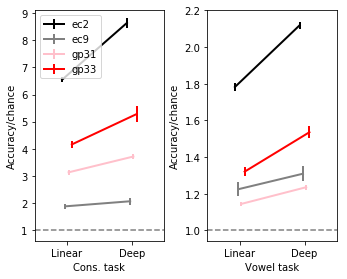

In [19]:
reload(accuracy)
plt.close()
f = plt.figure(figsize=(6, 4))

ax_c = f.add_axes([.2, .1, .3, .8])
ax_v = f.add_axes([.6, .1, .3, .8])

accuracy.plot_cv_accuracy(other_deep_accuracy['c'], other_linear_accuracy['c'],
                          chance[1, :, -1], subjects, colors, ax_c, 'Cons. task', ymax=9.1)
accuracy.plot_cv_accuracy(other_deep_accuracy['v'], other_linear_accuracy['v'],
                          chance[2, :, -1], subjects, colors, ax_v, 'Vowel task', False, ymax=2.2)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/c_v_accuracy.pdf'))

# P M Accuracy

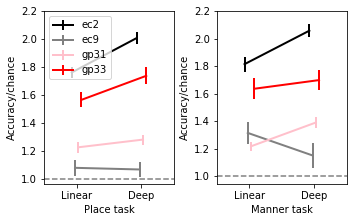

In [20]:
reload(accuracy)
plt.close()
f = plt.figure(figsize=(6, 3))

ax_c = f.add_axes([.2, .1, .3, .8])
ax_v = f.add_axes([.6, .1, .3, .8])

accuracy.plot_cv_accuracy(other_deep_accuracy['p'], other_linear_accuracy['p'],
                          chance[3, :, -1], subjects, colors, ax_c, 'Place task', ymax=2.2)
accuracy.plot_cv_accuracy(other_deep_accuracy['m'], other_linear_accuracy['m'],
                          chance[4, :, -1], subjects, colors, ax_v, 'Manner task', False, ymax=2.2)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/p_m_accuracy.pdf'))

# Slope

turn frac units into examples units


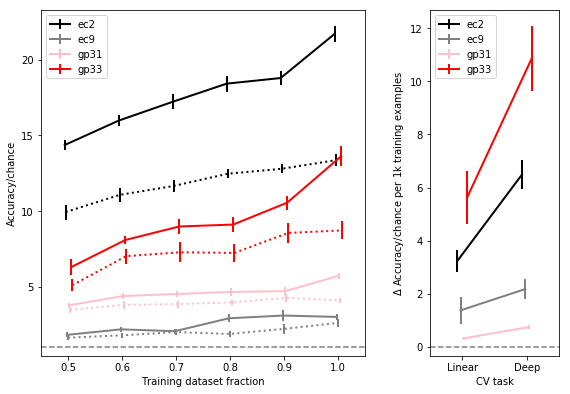

In [21]:
reload(slope)
plt.close()
f = plt.figure(figsize=(9, 6))

ax_ec2 = f.add_axes([.1, .1, .5, .8])
ax_slopes = f.add_axes([.70, .1, .2, .8])
slope.plot_cv_slope(deep_all, linear_all, chance[0], training_size, subjects, fracs, colors, (ax_ec2, ax_slopes))
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope.pdf'))